In [1]:
import numpy as np
import pytplot
from datetime import datetime
import scipy.signal as signal
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import pandas as pd
from pytplot import tplot, data_quants, store_data, options, split_vec, cdf_to_tplot, xlim, get_data
import sys
import os
import numpy as np
import math
import spiceypy as spice
import datetime
from datetime import datetime, timedelta
import pyspedas
import matplotlib.pyplot as plt
#plt.switch_backend('Agg')





def convert_string_to_datetime(input_string):
    elements = input_string.split()
    date_string = f"{elements[0]}-{elements[1]}T{elements[2].zfill(2)}:{elements[3].zfill(2)}:{elements[4].zfill(2)}.{elements[5]}"
    return date_string

def convert_date(input_date):
    date_object = datetime.strptime(input_date, '%Y-%jT%H:%M:%S.%f')
    return f'{date_object.strftime("%Y-%m-%d")}T{date_object.strftime("%H:%M:%S.%f")}'

def convert_to_float_list(input_list):
    return [list(map(float, sublist)) for sublist in input_list]


def lt_iauJup( TARGET: str, utc):
    """
    Args:
        TARGET: target in the Jupiter system (like EUROPA and JUNO)
        utc: observation date at the target (UT)

    Returns:
        td: local time in datetime [hh:mm:ss]
    """
    et = spice.str2et(utc)

    # Eigen vector toward the sun's position seen from Jupiter in IAU_JUPITER coordinate.
    posSUN, lighttime = spice.spkpos(
        targ='SUN', et=et, ref='IAU_JUPITER', abcorr='LT+S', obs='JUPITER'
    )
    posSUN = posSUN/math.sqrt(posSUN[0]**2 + posSUN[1]**2 + posSUN[2]**2)

    # Eigen vector toward target's position seen from Jupiter in IAU_JUPITER coordinate.
    posTARG, _ = spice.spkpos(
        targ=TARGET, et=et, ref='IAU_JUPITER', abcorr='NONE', obs='JUPITER'
    )
    posTARG = posTARG / \
        math.sqrt(posTARG[0]**2 + posTARG[1]**2 + posTARG[2]**2)

    # Dusk terminator
    dusk_term = np.array([-posSUN[1], posSUN[0]])
    dusk_dot = dusk_term[0]*posTARG[0] + dusk_term[1]*posTARG[1]
    if dusk_dot >= 0:
        # Target is in the dusk side.
        d_phi = np.pi + \
            math.acos(posSUN[0]*posTARG[0]+posSUN[1]*posTARG[1])
        print('Dusk [deg]:', math.degrees(d_phi))
    else:
        # Target is in the dawn side.
        d_phi = np.pi - \
            math.acos(posSUN[0]*posTARG[0] + posSUN[1]*posTARG[1])
        print('Dawn [deg]:', math.degrees(d_phi))

    sec = (3600*24/360)*math.degrees(d_phi)    # [sec]
    td = timedelta(seconds=sec)
    print(td)

    return td





def save_data_png(sts_file_path, window, shift):
    times, orbit_positions, magetic_fields = [], [], []

    with open(sts_file_path, 'r') as sts_file:
        for line in sts_file:
            parts = line.split()
            if len(parts) >= 10:
                times.append(' '.join(parts[0:6]))
                orbit_positions.append(parts[11:14])
                magetic_fields.append(parts[7:10])

    times = [convert_date(convert_string_to_datetime(time)) for time in times[2:]]
    orbit_positions = np.array(convert_to_float_list(orbit_positions[2:])) / 71492
    magetic_fields = np.array(convert_to_float_list(magetic_fields[2:]))

    pytplot.store_data('juno_mag', data={'x': np.array(times, dtype=np.datetime64), 'y': magetic_fields})
    pytplot.store_data('juno_orbit', data={'x': np.array(times, dtype=np.datetime64), 'y': orbit_positions})
    pytplot.options('juno_orbit', opt_dict={'ytitle': 'PC coordinate', 'ysubtitle': '[$R_J$]', 'legend_names': ['X', 'Y', 'Z']})

    data_x, data_y, data_z = magetic_fields.T

    norm = np.sqrt(data_x**2 + data_y**2 + data_z**2)
    pytplot.store_data('juno_mag_norm', data={'x': np.array(times, dtype=np.datetime64), 'y': norm})
    pytplot.options('juno_mag_norm', opt_dict={'legend_names': ['B'], 'ylog': 0, 'ytitle':'Total Mag', 'ysubtitle':'[$nT$]'})

    mag = data_quants['juno_mag']
    # サンプリング周波数の計算
    fs = len(mag) / (24 * 60 * 60)  # データの長さと1日の秒数から計算

    # 200秒間の移動平均を計算するためのサンプル数
    window_size_seconds = 200  # 秒
    window_size_samples = int(window_size_seconds * fs)

    # 移動平均を計算
    mag_avg = mag.rolling(time=window_size_samples, center=True).mean()

    store_data('juno_mag_smooth', data={'x': mag['time'], 'y': mag_avg})

    pytplot.split_vec('juno_mag_smooth')

    data_x = pytplot.get_data('juno_mag_smooth_x')
    data_y = pytplot.get_data('juno_mag_smooth_y')
    data_z = pytplot.get_data('juno_mag_smooth_z')

    rotmat=np.zeros((3, 3, (len(data_x[0]))))
    rotmat_t=np.zeros((3, 3, (len(data_x[0]))))

    for i in range(len(data_x[0])-1):
        bvec = [data_x[1][i], data_y[1][i], data_z[1][i]]
        zz = [0, 0, 1]

        yhat = np.cross(zz, bvec)
        xhat = np.cross(yhat, bvec)
        zhat = bvec

        yhat = yhat / np.linalg.norm(yhat)
        xhat = xhat / np.linalg.norm(xhat)
        zhat = zhat / np.linalg.norm(zhat)

        rotmat[:,:,i] = np.array([xhat, yhat, zhat])
        rotmat_t[:,:,i] = np.array([xhat, yhat, zhat]).T

    rot_mag = np.zeros((3, len(data_x[0])))

    pytplot.split_vec('juno_mag')
    d_x = pytplot.get_data('juno_mag_x')
    d_y = pytplot.get_data('juno_mag_y')
    d_z = pytplot.get_data('juno_mag_z')

    for i in range(len(d_x[0])-1):
        rot_mag[:,i] = np.dot(rotmat[:,:,i], [d_x[1][i], d_y[1][i], d_z[1][i]])

    store_data('juno_mag_rot', data={'x': mag['time'], 'y': rot_mag.T})

    norm_smooth = np.sqrt(mag_avg[:,0]**2 + mag_avg[:,1]**2 + mag_avg[:,2]**2)
    pytplot.split_vec('juno_mag_rot')

    perp = np.sqrt(data_quants['juno_mag_rot_y']**2 + data_quants['juno_mag_rot_x']**2)

    store_data('juno_mag_rot_perp', data={'x': mag['time'], 'y': perp})

    para = norm - norm_smooth

    store_data('juno_mag_rot_para', data={'x': mag['time'], 'y': para})

    ratio = perp / para

    store_data('juno_mag_rot_ratio', data={'x': mag['time'], 'y': ratio})

    options('juno_mag_rot_ratio', opt_dict={'ylog': 0, 'ytitle': 'Ratio', 'legend_names': ['Perp/Para'], 'yrange': [-5000, 5000]})


    yaxis_max = 0.04

    # データの取り出し
    base_time = pd.to_datetime(data_quants['juno_mag_rot_para']['time'][0].values)
    b_para = data_quants['juno_mag_rot_para']
    b_perp = data_quants['juno_mag_rot_perp']
    # サンプリング周波数の設定 (例: 1Hz)
    length = b_para.shape
    fs = length[0] / 24 / 60 / 60

    # スペクトログラムの計算
    f, t, Sxx = signal.spectrogram(b_para, fs, nperseg=window, noverlap=shift)

    # 時間の変換
    resulting_times = [(base_time + timedelta(seconds=time)).strftime('%Y-%m-%dT%H:%M:%S.%f') for time in t]
    middle_times = np.array(resulting_times, dtype=np.datetime64)

    # データの保存
    pytplot.store_data(f'para_{window}_{shift}', data={'x': middle_times, 'y': Sxx.T, 'v': f})

    f, t, Sxx = signal.spectrogram(b_perp, fs, nperseg=window, noverlap=shift)
    pytplot.store_data(f'perp_{window}_{shift}', data={'x': middle_times, 'y': Sxx.T, 'v': f})

    f, t, Sxx = signal.spectrogram(norm, fs, nperseg=window, noverlap=shift)
    pytplot.store_data(f'norm_{window}_{shift}', data={'x': middle_times, 'y': Sxx.T, 'v': f})

    pytplot.store_data(f'ratio_{window}_{shift}', data={'x': middle_times, 'y': data_quants[f'perp_{window}_{shift}']/data_quants[f'para_{window}_{shift}'], 'v': f})

    yrange = [0.008, fs/2]
    options(f'para_{window}_{shift}', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_para', 'Colormap': 'jet', 'yrange': yrange})
    options(f'perp_{window}_{shift}', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_perp', 'Colormap': 'jet', 'yrange': yrange})
    options(f'norm_{window}_{shift}', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_norm', 'Colormap': 'jet', 'yrange': yrange})
    options(f'ratio_{window}_{shift}', opt_dict={'zlog': False, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': 'Ratio', 'ytitle': 'perp/para', 'Colormap': 'Greys', 'yrange': yrange, 'zrange': [0, 10]})
    #tplot([f'para_{window}_{shift}', f'perp_{window}_{shift}', f'norm_{window}_{shift}', f'ratio_{window}_{shift}'], xsize=12, ysize=12)

    sys.path.append('/home/kooki/Documents/Juno_ULC_EMIC')
    import Juno_pos as jp


    RJ = 71492000
    pos_arr = data_quants['juno_orbit'] * RJ

    _, index = np.unique(pos_arr['time'], return_index=True)
    pos_arr = pos_arr.isel(time=index)

    # 時間をソート
    sorted_pos_arr = pos_arr.sortby('time')

    # 5分ごとのデータをサンプリング
    resampled_pos_arr = sorted_pos_arr.resample(time='1T').nearest()
    CLat = np.zeros(len(resampled_pos_arr['time']))
    Sys3 = np.zeros(len(resampled_pos_arr['time']))

    for i in range(len(resampled_pos_arr['time'])):
        CLat[i] = jp.Clat(np.array(resampled_pos_arr[i]))
        Sys3[i] = jp.S3(np.array(resampled_pos_arr[i]))


    sys.path.append('/home/kooki/Documents/Juno_ULC_EMIC/temp')
    import juice_spice_lib as jsl
    import juno_spice_lib as juno

    source_directory = '/home/kooki/Documents/Juno_ULC_EMIC/kernel/kernel/juno/'
    juno.spice_ini(source_directory)

    temp_utc = resampled_pos_arr['time'][0]
    con_s = (temp_utc.values).astype('datetime64[s]')


    if isinstance(con_s, np.datetime64):
        utc = np.datetime_as_string(con_s, unit='s')
    time_delta = lt_iauJup(TARGET='JUNO', utc=utc)

    hours = time_delta.total_seconds() / 3600.0
    #print(f"Local time: {hours} hours")

    lt = np.zeros(len(resampled_pos_arr['time']))
    for i in range(len(resampled_pos_arr['time'])):
        con_s = (resampled_pos_arr['time'][i].values).astype('datetime64[s]')
        if isinstance(con_s, np.datetime64):
            utc = np.datetime_as_string(con_s, unit='s')
        lt[i] = lt_iauJup(TARGET='JUNO', utc=utc).total_seconds() / 3600.0


    R = np.sqrt(resampled_pos_arr[:,0]**2 + resampled_pos_arr[:,1]**2 + resampled_pos_arr[:,2]**2) / RJ

    orb_data = np.zeros((len(resampled_pos_arr['time']), 4))
    orb_data[:,0] = R
    orb_data[:,1] = CLat
    orb_data[:,2] = Sys3
    orb_data[:,3] = lt

    store_data('juno_orbit_rclatsys3lt', data={'x': resampled_pos_arr['time'], 'y': orb_data})

    time_da = resampled_pos_arr['time'][10]
    date_only = str(time_da.values)[:10]
    date_only
    year = date_only[:4]
    month = date_only[5:7]
    year

    mh = 1.67262192369 * 1e-27
    mh2 = 1.6737 * 1e-27 * 2

    mo = 2.6567 * 1e-26
    mo2 = 2.6567 * 1e-26 * 2

    ms = 5.324 * 1e-26

    moh = mo + mh
    moh2 = mo + mh2

    mso = ms + mo
    mso2 = ms + mo2

    q = 1.60217662 * 1e-19

    pyspedas.tinterpol(names='juno_mag_norm', interp_to=f'ratio_{window}_{shift}', newname='juno_mag_norm_intpl')

    b = pytplot.data_quants['juno_mag_norm_intpl']

    label = ['H+', 'H2+', 'O+', 'O2+', 'S+', 'OH+', 'H2O+', 'SO+', 'SO2+']

    cyc_data = np.zeros((len(b['time']), 9))
    cyc_data[:,0] = 1 / (2 * np.pi) * q * b * 1e-9 / mh
    cyc_data[:,1] = 1 / (2 * np.pi) * q * b * 1e-9 / mh2
    cyc_data[:,2] = 1 / (2 * np.pi) * q * b * 1e-9 / mo
    cyc_data[:,3] = 1 / (2 * np.pi) * q * b * 1e-9 / mo2
    cyc_data[:,4] = 1 / (2 * np.pi) * q * b * 1e-9 / ms
    cyc_data[:,5] = 1 / (2 * np.pi) * q * b * 1e-9 / moh
    cyc_data[:,6] = 1 / (2 * np.pi) * q * b * 1e-9 / moh2
    cyc_data[:,7] = 1 / (2 * np.pi) * q * b * 1e-9 / mso
    cyc_data[:,8] = 1 / (2 * np.pi) * q * b * 1e-9 / mso2

    store_data('juno_cyc_freq', data={'x': b['time'], 'y': cyc_data})
    options('juno_cyc_freq', opt_dict={'ylog': 1, 'ytitle': 'Cyclotron Frequency', 'ysubtitle': '[$Hz$]', 'thick':2, 'linestyle': '-'})#,
                                        #'Color': ['red', 'red', 'green', 'green', 'black', 'blue', 'blue', 'purple', 'purple']})

    labels = split_vec('juno_orbit_rclatsys3lt')
    options('juno_orbit_rclatsys3lt_0', opt_dict={'ytitle': 'R[Rj]'})
    options('juno_orbit_rclatsys3lt_1', opt_dict={'ytitle': 'CLat[deg]'})
    options('juno_orbit_rclatsys3lt_2', opt_dict={'ytitle': 'Sys3[deg]'})
    options('juno_orbit_rclatsys3lt_3', opt_dict={'ytitle': 'LT[hours]'})

    store_data('para', data=['para_1024_1', 'juno_cyc_freq', 'para_1024_1'])
    store_data('perp', data=['perp_1024_1', 'juno_cyc_freq', 'perp_1024_1'])
    store_data('norm', data=['norm_1024_1', 'juno_cyc_freq', 'norm_1024_1'])
    store_data('ratio', data=['ratio_1024_1', 'juno_cyc_freq', 'ratio_1024_1'])

    time_ranges = [f"{date_only} {str(hour).zfill(2)}:00:00" for hour in range(0, 24, 3)]
    time_ranges.append(f"{date_only} 23:59:59")
    xlim(time_ranges[0], time_ranges[-1])
    save_dir = '/mnt/d/JUNO_EMIC/component/{}/{}/1day/'.format(year, month)
    os.makedirs(save_dir, exist_ok=True)
    tplot(['para', 'perp', 'norm', 'ratio'], xsize=12, ysize=18 ,var_label=labels, save_png=save_dir + date_only)
    plt.close()

    for t in range(len(time_ranges)-1):
        ptr = [time_ranges[t], time_ranges[t+1]]
        xlim(ptr[0], ptr[1])
        save_dir = '/mnt/d/JUNO_EMIC/component/{}/{}/3hours/'.format(year, month)
        os.makedirs(save_dir, exist_ok=True)
        tplot(['para', 'perp', 'norm', 'ratio'], xsize=12, ysize=18 ,var_label=labels, save_png=save_dir + ptr[0])
        plt.close()



    def remove_invalid_attrs(data_array):
        valid_types = (str, int, float, np.ndarray, list, tuple)
        attrs = {k: v for k, v in data_array.attrs.items() if isinstance(v, valid_types)}
        data_array.attrs = attrs


    juno_mag_norm = data_quants['juno_mag_norm' ]
    juno_mag_rot_perp = data_quants['juno_mag_rot_perp']
    juno_mag_rot_para = data_quants['juno_mag_rot_para']
    juno_cyc_freq = data_quants['juno_cyc_freq']
    para_1024_1 = data_quants['para_1024_1']
    perp_1024_1 = data_quants['perp_1024_1']
    norm_1024_1 = data_quants['norm_1024_1']
    ratio_1024_1 = data_quants['ratio_1024_1']
    juno_orbit_rclatsys3lt = data_quants['juno_orbit_rclatsys3lt']

    remove_invalid_attrs(juno_mag_norm)
    remove_invalid_attrs(juno_mag_rot_perp)
    remove_invalid_attrs(juno_mag_rot_para)
    remove_invalid_attrs(juno_cyc_freq)
    remove_invalid_attrs(para_1024_1)
    remove_invalid_attrs(perp_1024_1)
    remove_invalid_attrs(norm_1024_1)
    remove_invalid_attrs(ratio_1024_1)
    remove_invalid_attrs(juno_orbit_rclatsys3lt)

    # 複数の DataArray を Dataset にまとめる
    dataset = xr.Dataset({
        "juno_mag_norm": juno_mag_norm,
        "juno_mag_rot_perp": juno_mag_rot_perp,
        "juno_mag_rot_para": juno_mag_rot_para,
        "juno_cyc_freq": juno_cyc_freq
    })

    # ディレクトリを指定して保存
    mag_line = '/mnt/d/Juno_xarray/mag_line/{}/{}/'.format(year, month)
    os.makedirs(mag_line, exist_ok=True)
    file_path = mag_line + "mag_norm_perp_para_{}.nc".format(date_only)

    # ファイルが存在する場合は削除する
    if os.path.exists(file_path):
        os.remove(file_path)

    # データセットを保存する
    dataset.to_netcdf(file_path)

    dataset = xr.Dataset({
        "para_1024_1": para_1024_1,
        "perp_1024_1": perp_1024_1,
        "norm_1024_1": norm_1024_1,
        "ratio_1024_1": ratio_1024_1
    })

    mag_spec = '/mnt/d/Juno_xarray/mag_spec/{}/{}/'.format(year, month)
    os.makedirs(mag_spec, exist_ok=True)
    file_path = mag_spec + "spec1024_para_perp_norm_ratio_{}.nc".format(date_only)

    # ファイルが存在する場合は削除する
    if os.path.exists(file_path):
        os.remove(file_path)

    # データセットを保存する
    dataset.to_netcdf(file_path)

    orb = '/mnt/d/Juno_xarray/orb/{}/{}/'.format(year, month)
    os.makedirs(orb, exist_ok=True)
    file_path = orb + "orbit_rclatsys3lt_{}.nc".format(date_only)

    # ファイルが存在する場合は削除する
    if os.path.exists(file_path):
        os.remove(file_path)

    # データセットを保存する
    juno_orbit_rclatsys3lt.to_netcdf(file_path)
    #pytplot.del_data()

window = 1024
shift = 1

20-Jun-24 14:46:52: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/store_data.py:219: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp = xr.DataArray(values, dims=['time']+dimension_list,

20-Jun-24 14:46:52: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/store_data.py:219: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This war

Dusk [deg]: 280.26699050734317
18:41:04.077722
Dusk [deg]: 280.26699050734317
18:41:04.077722
Dusk [deg]: 280.2640587452529
18:41:03.374099
Dusk [deg]: 280.26111660650173
18:41:02.667986
Dusk [deg]: 280.25816403057894
18:41:01.959367
Dusk [deg]: 280.25520095636165
18:41:01.248230
Dusk [deg]: 280.25222732209477
18:41:00.534557
Dusk [deg]: 280.24924306538287
18:40:59.818336
Dusk [deg]: 280.2462481231546
18:40:59.099550
Dusk [deg]: 280.2432424316511
18:40:58.378184
Dusk [deg]: 280.2402259264004
18:40:57.654222
Dusk [deg]: 280.2371985421916
18:40:56.927650
Dusk [deg]: 280.2341602130475
18:40:56.198451
Dusk [deg]: 280.2311108721945
18:40:55.466609
Dusk [deg]: 280.22805045202927
18:40:54.732108
Dusk [deg]: 280.2249788840831
18:40:53.994932
Dusk [deg]: 280.2218960989819
18:40:53.255064
Dusk [deg]: 280.21880202640256
18:40:52.512486
Dusk [deg]: 280.21569659502416
18:40:51.767183
Dusk [deg]: 280.2125797324746
18:40:51.019136
Dusk [deg]: 280.2094513652704
18:40:50.268328
Dusk [deg]: 280.20631141

20-Jun-24 14:52:44: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:423: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  xaxis_ticks_dt = [np.datetime64(mpl.dates.num2date(tick_val).isoformat()) for tick_val in xaxis_ticks]

20-Jun-24 14:52:44: /home/kooki/Documents/Juno_ULC_EMIC/.venv/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:618: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_ticks.append('{:.2f}'.format(var_xr.interp(coords={'time': time}, kwargs={'fill

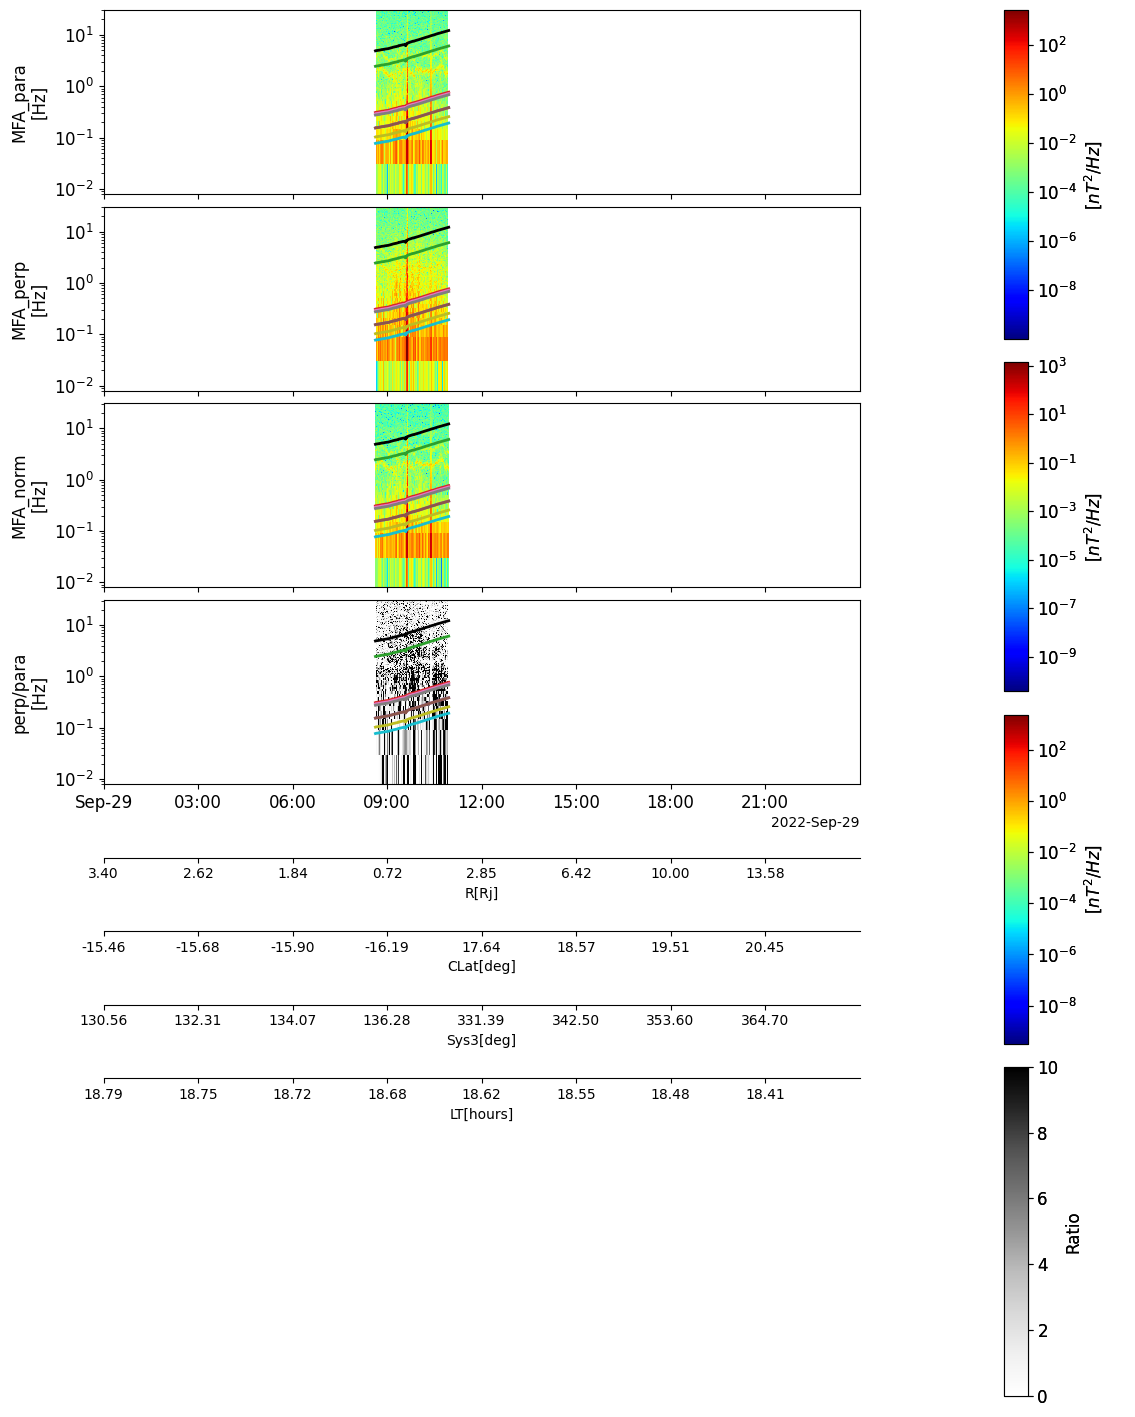

' \ndef remove_invalid_attrs(data_array):\n    valid_types = (str, int, float, np.ndarray, list, tuple)\n    attrs = {k: v for k, v in data_array.attrs.items() if isinstance(v, valid_types)}\n    data_array.attrs = attrs\n\n\njuno_mag_norm = data_quants[\'juno_mag_norm\' ]\njuno_mag_rot_perp = data_quants[\'juno_mag_rot_perp\']\njuno_mag_rot_para = data_quants[\'juno_mag_rot_para\']\njuno_cyc_freq = data_quants[\'juno_cyc_freq\']\npara_1024_1 = data_quants[\'para_1024_1\']\nperp_1024_1 = data_quants[\'perp_1024_1\']\nnorm_1024_1 = data_quants[\'norm_1024_1\']\nratio_1024_1 = data_quants[\'ratio_1024_1\']\njuno_orbit_rclatsys3lt = data_quants[\'juno_orbit_rclatsys3lt\']\n\nremove_invalid_attrs(juno_mag_norm)\nremove_invalid_attrs(juno_mag_rot_perp)\nremove_invalid_attrs(juno_mag_rot_para)\nremove_invalid_attrs(juno_cyc_freq)\nremove_invalid_attrs(para_1024_1)\nremove_invalid_attrs(perp_1024_1)\nremove_invalid_attrs(norm_1024_1)\nremove_invalid_attrs(ratio_1024_1)\nremove_invalid_attrs(j

In [2]:
sts_file_path = '/mnt/d/JUNO_EMIC/event/fgm_jno_l3_2022272pc_eu_v02.sts'

window = 1024
shift = 1

#save_data_png(file_path, window, shift)

times, orbit_positions, magetic_fields = [], [], []

with open(sts_file_path, 'r') as sts_file:
    for line in sts_file:
        parts = line.split()
        if len(parts) >= 10:
            times.append(' '.join(parts[0:6]))
            orbit_positions.append(parts[11:14])
            magetic_fields.append(parts[7:10])

times = [convert_date(convert_string_to_datetime(time)) for time in times[2:]]
orbit_positions = np.array(convert_to_float_list(orbit_positions[2:])) / 71492
magetic_fields = np.array(convert_to_float_list(magetic_fields[2:]))

pytplot.store_data('juno_mag', data={'x': np.array(times, dtype=np.datetime64), 'y': magetic_fields})
pytplot.store_data('juno_orbit', data={'x': np.array(times, dtype=np.datetime64), 'y': orbit_positions})
pytplot.options('juno_orbit', opt_dict={'ytitle': 'PC coordinate', 'ysubtitle': '[$R_J$]', 'legend_names': ['X', 'Y', 'Z']})

data_x, data_y, data_z = magetic_fields.T

norm = np.sqrt(data_x**2 + data_y**2 + data_z**2)
pytplot.store_data('juno_mag_norm', data={'x': np.array(times, dtype=np.datetime64), 'y': norm})
pytplot.options('juno_mag_norm', opt_dict={'legend_names': ['B'], 'ylog': 0, 'ytitle':'Total Mag', 'ysubtitle':'[$nT$]'})

mag = data_quants['juno_mag']
# サンプリング周波数の計算
#fs = len(mag) / (24 * 60 * 60)  # データの長さと1日の秒数から計算

start_time = datetime.fromisoformat(times[0])
end_time = datetime.fromisoformat(times[-1])

# 時間差を計算
time_difference = end_time - start_time
seconds_difference = time_difference.total_seconds()

fs =  len(mag) / seconds_difference

# 200秒間の移動平均を計算するためのサンプル数
window_size_seconds = 200  # 秒
window_size_samples = int(window_size_seconds * fs)

# 移動平均を計算
mag_avg = mag.rolling(time=window_size_samples, center=True).mean()

store_data('juno_mag_smooth', data={'x': mag['time'], 'y': mag_avg})

pytplot.split_vec('juno_mag_smooth')

data_x = pytplot.get_data('juno_mag_smooth_x')
data_y = pytplot.get_data('juno_mag_smooth_y')
data_z = pytplot.get_data('juno_mag_smooth_z')

rotmat=np.zeros((3, 3, (len(data_x[0]))))
rotmat_t=np.zeros((3, 3, (len(data_x[0]))))

for i in range(len(data_x[0])-1):
    bvec = [data_x[1][i], data_y[1][i], data_z[1][i]]
    zz = [0, 0, 1]

    yhat = np.cross(zz, bvec)
    xhat = np.cross(yhat, bvec)
    zhat = bvec

    yhat = yhat / np.linalg.norm(yhat)
    xhat = xhat / np.linalg.norm(xhat)
    zhat = zhat / np.linalg.norm(zhat)

    rotmat[:,:,i] = np.array([xhat, yhat, zhat])
    rotmat_t[:,:,i] = np.array([xhat, yhat, zhat]).T

rot_mag = np.zeros((3, len(data_x[0])))

pytplot.split_vec('juno_mag')
d_x = pytplot.get_data('juno_mag_x')
d_y = pytplot.get_data('juno_mag_y')
d_z = pytplot.get_data('juno_mag_z')

for i in range(len(d_x[0])-1):
    rot_mag[:,i] = np.dot(rotmat[:,:,i], [d_x[1][i], d_y[1][i], d_z[1][i]])

store_data('juno_mag_rot', data={'x': mag['time'], 'y': rot_mag.T})

norm_smooth = np.sqrt(mag_avg[:,0]**2 + mag_avg[:,1]**2 + mag_avg[:,2]**2)
pytplot.split_vec('juno_mag_rot')

perp = np.sqrt(data_quants['juno_mag_rot_y']**2 + data_quants['juno_mag_rot_x']**2)

store_data('juno_mag_rot_perp', data={'x': mag['time'], 'y': perp})

para = norm - norm_smooth

store_data('juno_mag_rot_para', data={'x': mag['time'], 'y': para})

ratio = perp / para

store_data('juno_mag_rot_ratio', data={'x': mag['time'], 'y': ratio})

options('juno_mag_rot_ratio', opt_dict={'ylog': 0, 'ytitle': 'Ratio', 'legend_names': ['Perp/Para'], 'yrange': [-5000, 5000]})


yaxis_max = 0.04

# データの取り出し
base_time = pd.to_datetime(data_quants['juno_mag_rot_para']['time'][0].values)
b_para = data_quants['juno_mag_rot_para']
b_perp = data_quants['juno_mag_rot_perp']
# サンプリング周波数の設定 (例: 1Hz)
length = b_para.shape
#fs = length[0] / 24 / 60 / 60

# スペクトログラムの計算
f, t, Sxx = signal.spectrogram(b_para, fs, nperseg=window, noverlap=shift)

# 時間の変換
resulting_times = [(base_time + timedelta(seconds=time)).strftime('%Y-%m-%dT%H:%M:%S.%f') for time in t]
middle_times = np.array(resulting_times, dtype=np.datetime64)

# データの保存
pytplot.store_data(f'para_{window}_{shift}', data={'x': middle_times, 'y': Sxx.T, 'v': f})

f, t, Sxx = signal.spectrogram(b_perp, fs, nperseg=window, noverlap=shift)
pytplot.store_data(f'perp_{window}_{shift}', data={'x': middle_times, 'y': Sxx.T, 'v': f})

f, t, Sxx = signal.spectrogram(norm, fs, nperseg=window, noverlap=shift)
pytplot.store_data(f'norm_{window}_{shift}', data={'x': middle_times, 'y': Sxx.T, 'v': f})

pytplot.store_data(f'ratio_{window}_{shift}', data={'x': middle_times, 'y': data_quants[f'perp_{window}_{shift}']/data_quants[f'para_{window}_{shift}'], 'v': f})

yrange = [0.008, fs/2]
options(f'para_{window}_{shift}', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_para', 'Colormap': 'jet', 'yrange': yrange})
options(f'perp_{window}_{shift}', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_perp', 'Colormap': 'jet', 'yrange': yrange})
options(f'norm_{window}_{shift}', opt_dict={'zlog': True, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'ytitle': 'MFA_norm', 'Colormap': 'jet', 'yrange': yrange})
options(f'ratio_{window}_{shift}', opt_dict={'zlog': False, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': 'Ratio', 'ytitle': 'perp/para', 'Colormap': 'Greys', 'yrange': yrange, 'zrange': [0, 10]})
#tplot([f'para_{window}_{shift}', f'perp_{window}_{shift}', f'norm_{window}_{shift}', f'ratio_{window}_{shift}'], xsize=12, ysize=12)

sys.path.append('/home/kooki/Documents/Juno_ULC_EMIC')
import Juno_pos as jp


RJ = 1560
pos_arr = data_quants['juno_orbit'] * RJ

_, index = np.unique(pos_arr['time'], return_index=True)
pos_arr = pos_arr.isel(time=index)

# 時間をソート
sorted_pos_arr = pos_arr.sortby('time')

# 5分ごとのデータをサンプリング
resampled_pos_arr = sorted_pos_arr.resample(time='1T').nearest()
CLat = np.zeros(len(resampled_pos_arr['time']))
Sys3 = np.zeros(len(resampled_pos_arr['time']))

for i in range(len(resampled_pos_arr['time'])):
    CLat[i] = jp.Clat(np.array(resampled_pos_arr[i]))
    Sys3[i] = jp.S3(np.array(resampled_pos_arr[i]))


sys.path.append('/home/kooki/Documents/Juno_ULC_EMIC/temp')
import juice_spice_lib as jsl
import juno_spice_lib as juno

source_directory = '/home/kooki/Documents/Juno_ULC_EMIC/kernel/kernel/juno/'
juno.spice_ini(source_directory)

temp_utc = resampled_pos_arr['time'][0]
con_s = (temp_utc.values).astype('datetime64[s]')


if isinstance(con_s, np.datetime64):
    utc = np.datetime_as_string(con_s, unit='s')
time_delta = lt_iauJup(TARGET='JUNO', utc=utc)

hours = time_delta.total_seconds() / 3600.0
#print(f"Local time: {hours} hours")

lt = np.zeros(len(resampled_pos_arr['time']))
for i in range(len(resampled_pos_arr['time'])):
    con_s = (resampled_pos_arr['time'][i].values).astype('datetime64[s]')
    if isinstance(con_s, np.datetime64):
        utc = np.datetime_as_string(con_s, unit='s')
    lt[i] = lt_iauJup(TARGET='JUNO', utc=utc).total_seconds() / 3600.0


R = np.sqrt(resampled_pos_arr[:,0]**2 + resampled_pos_arr[:,1]**2 + resampled_pos_arr[:,2]**2) / RJ

orb_data = np.zeros((len(resampled_pos_arr['time']), 4))
orb_data[:,0] = R
orb_data[:,1] = CLat
orb_data[:,2] = Sys3
orb_data[:,3] = lt

store_data('juno_orbit_rclatsys3lt', data={'x': resampled_pos_arr['time'], 'y': orb_data})

time_da = resampled_pos_arr['time'][10]
date_only = str(time_da.values)[:10]
date_only
year = date_only[:4]
month = date_only[5:7]
year

mh = 1.67262192369 * 1e-27
mh2 = 1.6737 * 1e-27 * 2

mo = 2.6567 * 1e-26
mo2 = 2.6567 * 1e-26 * 2

ms = 5.324 * 1e-26

moh = mo + mh
moh2 = mo + mh2

mso = ms + mo
mso2 = ms + mo2

q = 1.60217662 * 1e-19

pyspedas.tinterpol(names='juno_mag_norm', interp_to=f'ratio_{window}_{shift}', newname='juno_mag_norm_intpl')

b = pytplot.data_quants['juno_mag_norm_intpl']

label = ['H+', 'H2+', 'O+', 'O2+', 'S+', 'OH+', 'H2O+', 'SO+', 'SO2+']

cyc_data = np.zeros((len(b['time']), 9))
cyc_data[:,0] = 1 / (2 * np.pi) * q * b * 1e-9 / mh
cyc_data[:,1] = 1 / (2 * np.pi) * q * b * 1e-9 / mh2
cyc_data[:,2] = 1 / (2 * np.pi) * q * b * 1e-9 / mo
cyc_data[:,3] = 1 / (2 * np.pi) * q * b * 1e-9 / mo2
cyc_data[:,4] = 1 / (2 * np.pi) * q * b * 1e-9 / ms
cyc_data[:,5] = 1 / (2 * np.pi) * q * b * 1e-9 / moh
cyc_data[:,6] = 1 / (2 * np.pi) * q * b * 1e-9 / moh2
cyc_data[:,7] = 1 / (2 * np.pi) * q * b * 1e-9 / mso
cyc_data[:,8] = 1 / (2 * np.pi) * q * b * 1e-9 / mso2

store_data('juno_cyc_freq', data={'x': b['time'], 'y': cyc_data})
options('juno_cyc_freq', opt_dict={'ylog': 1, 'ytitle': 'Cyclotron Frequency', 'ysubtitle': '[$Hz$]', 'thick':2, 'linestyle': '-'})#,
                                    #'Color': ['red', 'red', 'green', 'green', 'black', 'blue', 'blue', 'purple', 'purple']})

labels = split_vec('juno_orbit_rclatsys3lt')
options('juno_orbit_rclatsys3lt_0', opt_dict={'ytitle': 'R[Rj]'})
options('juno_orbit_rclatsys3lt_1', opt_dict={'ytitle': 'CLat[deg]'})
options('juno_orbit_rclatsys3lt_2', opt_dict={'ytitle': 'Sys3[deg]'})
options('juno_orbit_rclatsys3lt_3', opt_dict={'ytitle': 'LT[hours]'})

store_data('para', data=['para_1024_1', 'juno_cyc_freq', 'para_1024_1'])
store_data('perp', data=['perp_1024_1', 'juno_cyc_freq', 'perp_1024_1'])
store_data('norm', data=['norm_1024_1', 'juno_cyc_freq', 'norm_1024_1'])
store_data('ratio', data=['ratio_1024_1', 'juno_cyc_freq', 'ratio_1024_1'])

time_ranges = [f"{date_only} {str(hour).zfill(2)}:00:00" for hour in range(0, 24, 3)]
time_ranges.append(f"{date_only} 23:59:59")
xlim(time_ranges[0], time_ranges[-1])
save_dir = '/mnt/d/JUNO_EMIC/component/{}/{}/1day/'.format(year, month)
os.makedirs(save_dir, exist_ok=True)
tplot(['para', 'perp', 'norm', 'ratio'], xsize=12, ysize=18 ,var_label=labels)#, save_png=save_dir + date_only)
plt.close()

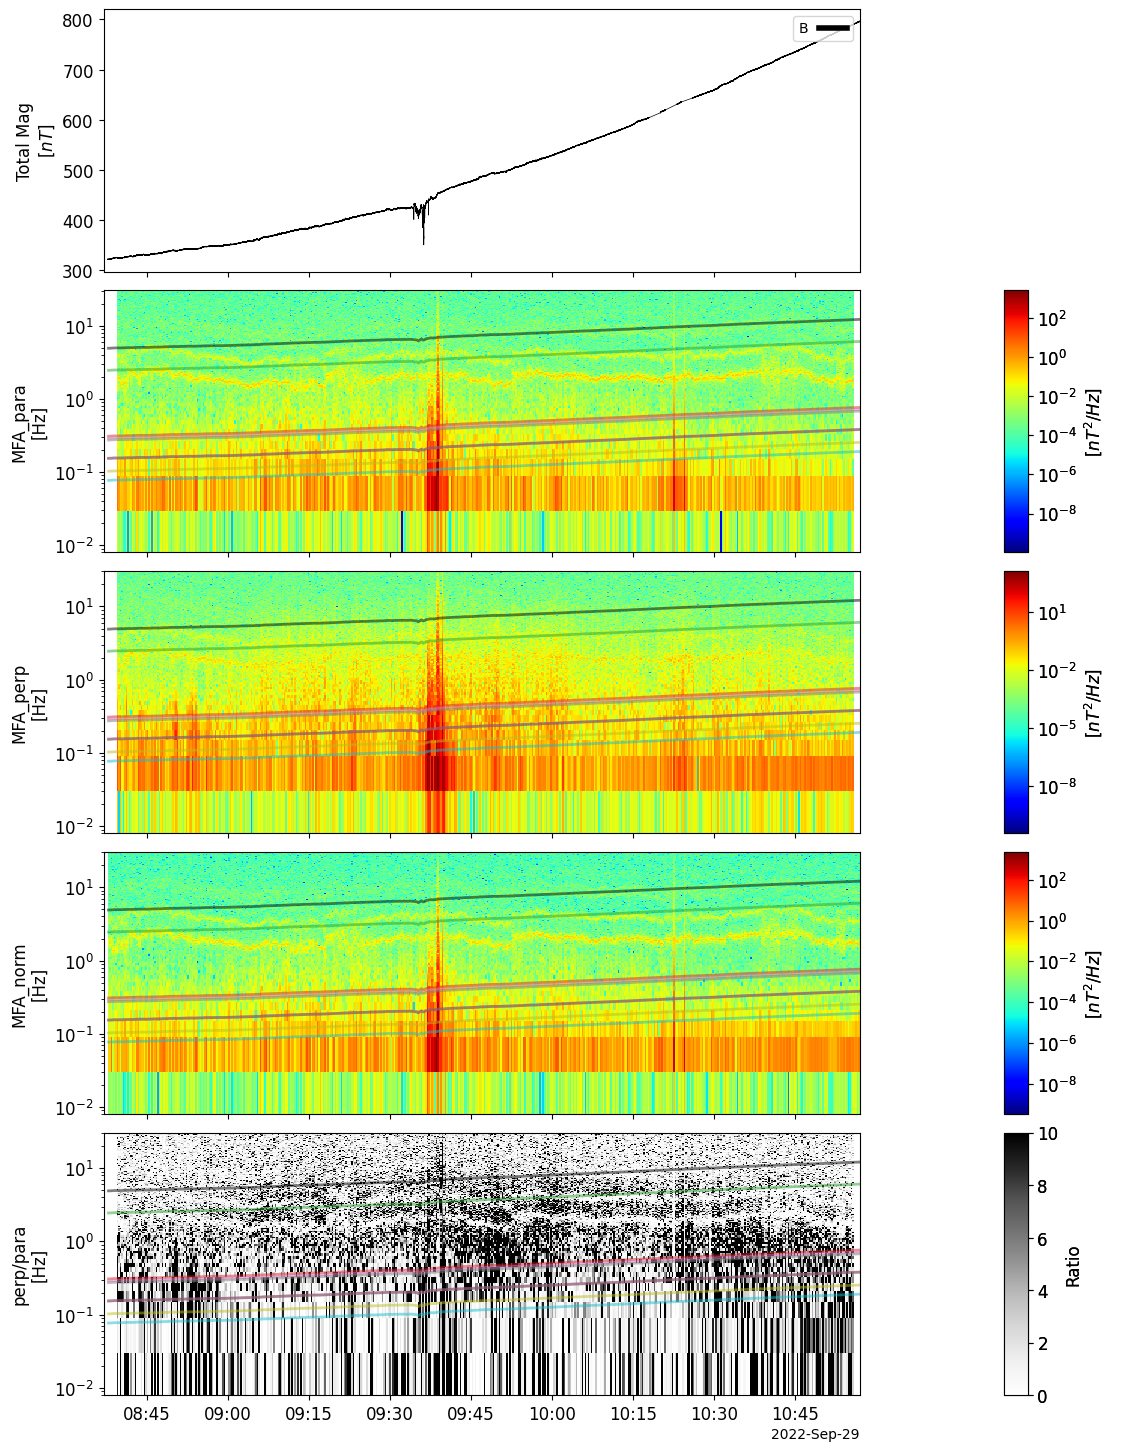

In [11]:

xlim('2022-09-29 08:37:00', '2022-09-29 10:56:59')
options('juno_cyc_freq', opt_dict={'ylog': 1, 'ytitle': 'Cyclotron Frequency', 'ysubtitle': '[$Hz$]', 'thick':2, 'linestyle': '-', 'alpha':0.5})
options(f'ratio_{window}_{shift}', opt_dict={'zlog': False, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': 'Ratio', 'ytitle': 'perp/para', 'Colormap': 'Greys', 'yrange': yrange, 'zrange': [0, 10]})
tplot(['juno_mag_norm' ,'para', 'perp', 'norm', 'ratio'], xsize=12, ysize=18 )

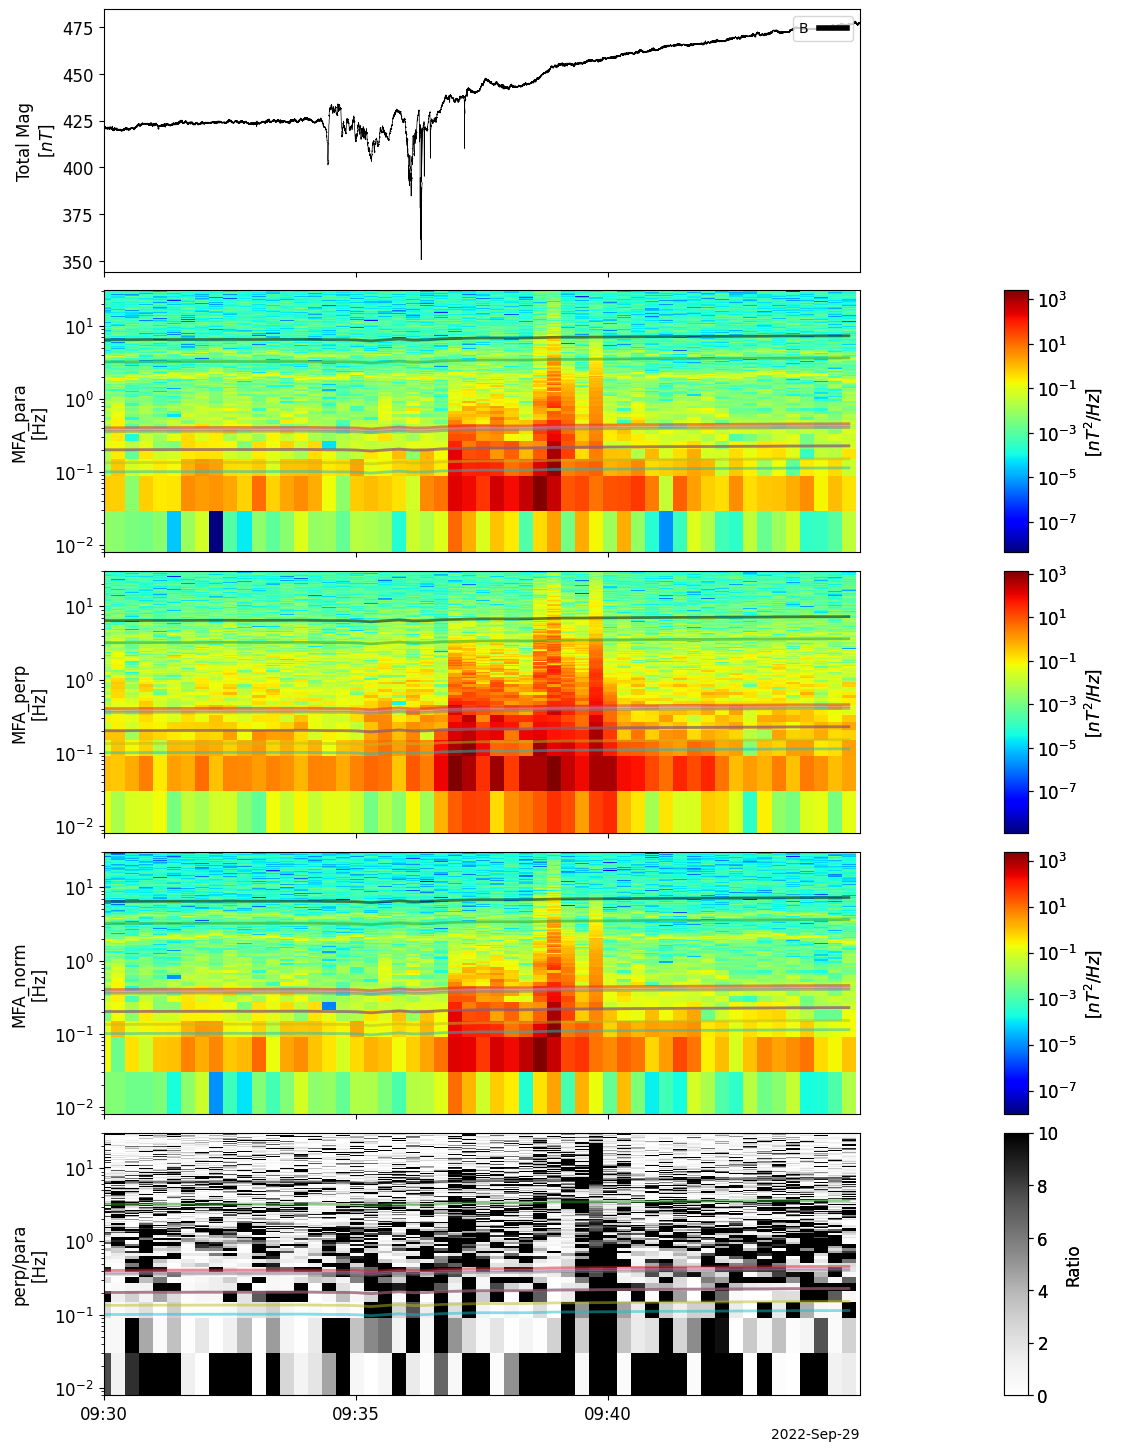

In [10]:


xlim('2022-09-29 09:30:00', '2022-09-29 09:44:59')
options('juno_cyc_freq', opt_dict={'ylog': 1, 'ytitle': 'Cyclotron Frequency', 'ysubtitle': '[$Hz$]', 'thick':2, 'linestyle': '-', 'alpha':0.5})
options(f'ratio_{window}_{shift}', opt_dict={'zlog': False, 'ylog': 1, 'ysubtitle': '[Hz]', 'spec': True, 'ztitle': 'Ratio', 'ytitle': 'perp/para', 'Colormap': 'Greys', 'yrange': yrange, 'zrange': [0, 10]})
tplot(['juno_mag_norm' ,'para', 'perp', 'norm', 'ratio'], xsize=12, ysize=18 )

In [5]:
pytplot.tplot_names()

0 : juno_mag
1 : juno_orbit
2 : juno_mag_norm
3 : juno_mag_smooth
4 : juno_mag_smooth_x
5 : juno_mag_smooth_y
6 : juno_mag_smooth_z
7 : juno_mag_x
8 : juno_mag_y
9 : juno_mag_z
10 : juno_mag_rot
11 : juno_mag_rot_x
12 : juno_mag_rot_y
13 : juno_mag_rot_z
14 : juno_mag_rot_perp
15 : juno_mag_rot_para
16 : juno_mag_rot_ratio
17 : para_1024_1
18 : perp_1024_1
19 : norm_1024_1
20 : ratio_1024_1
21 : juno_orbit_rclatsys3lt
22 : juno_mag_norm_intpl
23 : juno_cyc_freq
24 : juno_orbit_rclatsys3lt_0
25 : juno_orbit_rclatsys3lt_1
26 : juno_orbit_rclatsys3lt_2
27 : juno_orbit_rclatsys3lt_3
28 : para  data from:  juno_cyc_freq para_1024_1
29 : perp  data from:  juno_cyc_freq perp_1024_1
30 : norm  data from:  juno_cyc_freq norm_1024_1
31 : ratio  data from:  juno_cyc_freq ratio_1024_1


['juno_mag',
 'juno_orbit',
 'juno_mag_norm',
 'juno_mag_smooth',
 'juno_mag_smooth_x',
 'juno_mag_smooth_y',
 'juno_mag_smooth_z',
 'juno_mag_x',
 'juno_mag_y',
 'juno_mag_z',
 'juno_mag_rot',
 'juno_mag_rot_x',
 'juno_mag_rot_y',
 'juno_mag_rot_z',
 'juno_mag_rot_perp',
 'juno_mag_rot_para',
 'juno_mag_rot_ratio',
 'para_1024_1',
 'perp_1024_1',
 'norm_1024_1',
 'ratio_1024_1',
 'juno_orbit_rclatsys3lt',
 'juno_mag_norm_intpl',
 'juno_cyc_freq',
 'juno_orbit_rclatsys3lt_0',
 'juno_orbit_rclatsys3lt_1',
 'juno_orbit_rclatsys3lt_2',
 'juno_orbit_rclatsys3lt_3',
 'para  data from:  juno_cyc_freq para_1024_1',
 'perp  data from:  juno_cyc_freq perp_1024_1',
 'norm  data from:  juno_cyc_freq norm_1024_1',
 'ratio  data from:  juno_cyc_freq ratio_1024_1']

In [ ]:

""" for t in range(len(time_ranges)-1):
    ptr = [time_ranges[t], time_ranges[t+1]]
    xlim(ptr[0], ptr[1])
    save_dir = '/mnt/d/JUNO_EMIC/component/{}/{}/3hours/'.format(year, month)
    os.makedirs(save_dir, exist_ok=True)
    tplot(['para', 'perp', 'norm', 'ratio'], xsize=12, ysize=18 ,var_label=labels)#, save_png=save_dir + ptr[0])
    plt.close() """



def remove_invalid_attrs(data_array):
    valid_types = (str, int, float, np.ndarray, list, tuple)
    attrs = {k: v for k, v in data_array.attrs.items() if isinstance(v, valid_types)}
    data_array.attrs = attrs


juno_mag_norm = data_quants['juno_mag_norm' ]
juno_mag_rot_perp = data_quants['juno_mag_rot_perp']
juno_mag_rot_para = data_quants['juno_mag_rot_para']
juno_cyc_freq = data_quants['juno_cyc_freq']
para_1024_1 = data_quants['para_1024_1']
perp_1024_1 = data_quants['perp_1024_1']
norm_1024_1 = data_quants['norm_1024_1']
ratio_1024_1 = data_quants['ratio_1024_1']
juno_orbit_rclatsys3lt = data_quants['juno_orbit_rclatsys3lt']

remove_invalid_attrs(juno_mag_norm)
remove_invalid_attrs(juno_mag_rot_perp)
remove_invalid_attrs(juno_mag_rot_para)
remove_invalid_attrs(juno_cyc_freq)
remove_invalid_attrs(para_1024_1)
remove_invalid_attrs(perp_1024_1)
remove_invalid_attrs(norm_1024_1)
remove_invalid_attrs(ratio_1024_1)
remove_invalid_attrs(juno_orbit_rclatsys3lt)

# 複数の DataArray を Dataset にまとめる
dataset = xr.Dataset({
    "juno_mag_norm": juno_mag_norm,
    "juno_mag_rot_perp": juno_mag_rot_perp,
    "juno_mag_rot_para": juno_mag_rot_para,
    "juno_cyc_freq": juno_cyc_freq
})

# ディレクトリを指定して保存
mag_line = '/mnt/d/Juno_xarray/mag_line/{}/{}/'.format(year, month)
os.makedirs(mag_line, exist_ok=True)
file_path = mag_line + "mag_norm_perp_para_{}.nc".format(date_only)

# ファイルが存在する場合は削除する
if os.path.exists(file_path):
    os.remove(file_path)

# データセットを保存する
dataset.to_netcdf(file_path)

dataset = xr.Dataset({
    "para_1024_1": para_1024_1,
    "perp_1024_1": perp_1024_1,
    "norm_1024_1": norm_1024_1,
    "ratio_1024_1": ratio_1024_1
})

mag_spec = '/mnt/d/Juno_xarray/mag_spec/{}/{}/'.format(year, month)
os.makedirs(mag_spec, exist_ok=True)
file_path = mag_spec + "spec1024_para_perp_norm_ratio_{}.nc".format(date_only)

# ファイルが存在する場合は削除する
if os.path.exists(file_path):
    os.remove(file_path)

# データセットを保存する
dataset.to_netcdf(file_path)

orb = '/mnt/d/Juno_xarray/orb/{}/{}/'.format(year, month)
os.makedirs(orb, exist_ok=True)
file_path = orb + "orbit_rclatsys3lt_{}.nc".format(date_only)

# ファイルが存在する場合は削除する
if os.path.exists(file_path):
    os.remove(file_path)

# データセットを保存する
juno_orbit_rclatsys3lt.to_netcdf(file_path)

In [ ]:
""" 'para_1024_1',
 'perp_1024_1',
 'norm_1024_1',
 'ratio_1024_1',
 'juno_orbit_rclatsys3lt' """

labels = pytplot.split_vec('juno_orbit_rclatsys3lt')
options('juno_orbit_rclatsys3lt_0', opt_dict={'ytitle': 'R[Rj]'})



In [6]:
data

<xarray.DataArray 'para_1024_1' (time: 502, v_dim: 513)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [3.34210217e-06, 3.50014510e-06, 1.08636691e-07, ...,
        3.65708376e+00, 2.59252315e+00, 1.37955185e+00],
       [1.07280726e-04, 1.05205919e-05, 3.78247879e-06, ...,
        2.18328224e+00, 9.71393187e-01, 4.07513358e-02],
       ...,
       [2.07389443e-05, 1.19077840e-06, 1.21563163e-07, ...,
        1.19198909e+00, 1.02695004e+00, 2.47940822e-02],
       [1.09158035e-03, 5.56047444e-05, 2.96261492e-05, ...,
        6.17483335e-01, 5.50398973e-01, 9.17541490e-02],
       [2.40908183e-05, 2.88859673e-07, 1.75452447e-06, ...,
        7.49414356e-01, 3.61182990e-01, 5.79532119e-01]])
Coordinates:
  * time       (time) datetime64[ns] 2022-09-29T17:20:07.230178 ... 2023-09-2...
    spec_bins  (v_dim) float64 0.0 1.595e-05 3.191e-05 ... 0.008152 0.008168
    v          (v_dim) float64 0.0 1.595e-05 3.191e-05 ... 0.008152 0.008168
Dimensions without coordinates: v_dim
Attributes:
    plot_options:  {'xaxis_opt': {'axis_label': 'Time', 'crosshair': 'X', 'x_...

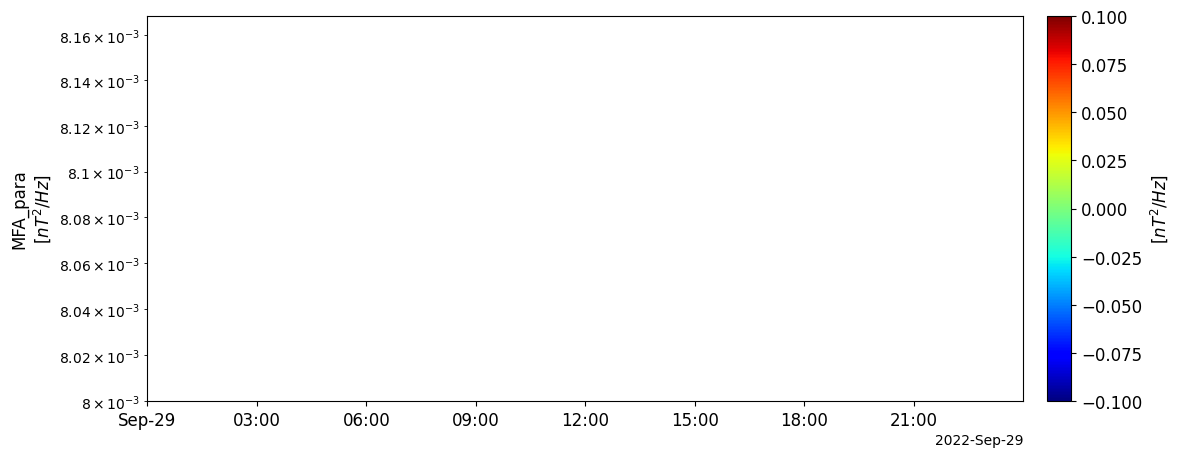

In [5]:
data = data_quants['para_1024_1']
spec = data_quants['para_1024_1']['v']

store_data('para', data={'x': data['time'], 'y': data, 'v': spec})
options('para', opt_dict={'ylog': 1, 'ytitle': 'MFA_para', 'ysubtitle': '[$nT^2/Hz$]', 'spec': True, 'ztitle': '[$nT^2/Hz$]', 'Colormap': 'jet', 'yrange': [0.008, fs/2]})
tplot('para')

In [12]:
options('para_1024_1', opt_dict={'yrange': [0.008, fs/2]})

tplot(['para_1024_1'])

ValueError: Invalid vmin or vmax

In [3]:
juno_mag_norm

NameError: name 'juno_mag_norm' is not defined

In [14]:
Rj

<xarray.DataArray 'juno_orbit_rclatsys3lt' (time: 141)>
array([1.16260726, 1.15827924, 1.13847103, 1.11866383, 1.09885761,
       1.07905239, 1.05924814, 1.0394449 , 1.01964264, 0.99984137,
       0.9800411 , 0.96024183, 0.94044354, 0.92064627, 0.90085002,
       0.88105478, 0.86126058, 0.84146743, 0.82167534, 0.80188435,
       0.78209445, 0.76230568, 0.7425181 , 0.7227317 , 0.70294652,
       0.68316265, 0.66338012, 0.64359899, 0.62381933, 0.60404123,
       0.58426479, 0.56449013, 0.54471736, 0.52494666, 0.50517819,
       0.48541219, 0.46564888, 0.44618188, 0.42642491, 0.40667173,
       0.38692287, 0.36717898, 0.34744085, 0.32770947, 0.30798608,
       0.2882723 , 0.26857019, 0.24888249, 0.22921289, 0.20956649,
       0.18965958, 0.17008521, 0.15056805, 0.13113376, 0.11182582,
       0.09272358, 0.0739873 , 0.05598717, 0.03974007, 0.02843821,
       0.02869708, 0.04029441, 0.05664369, 0.07468385, 0.09343921,
       0.11255214, 0.13186689, 0.15130601, 0.17082698, 0.19040458,
       0.21002296, 0.2296717 , 0.24934369, 0.26903385, 0.28873853,
       0.30845501, 0.32818123, 0.34791563, 0.36765694, 0.38740419,
       0.4071566 , 0.42691354, 0.44667449, 0.46643902, 0.48620678,
       0.50597748, 0.52575089, 0.54552677, 0.565305  , 0.58508539,
       0.60486783, 0.62465223, 0.64443849, 0.66422653, 0.68401632,
       0.70380776, 0.72360085, 0.74339553, 0.76319179, 0.78298959,
       0.80278892, 0.82258977, 0.82328593, 0.86380512, 0.88200135,
       0.88269767, 0.92322609, 0.94143163, 0.94212294, 0.98266068,
       1.00087044, 1.02068647, 1.04050406, 1.06032325, 1.08014404,
       1.09996645, 1.11979049, 1.13961622, 1.15944361, 1.17927272,
       1.19910355, 1.21893614, 1.23877052, 1.2586067 , 1.27844471,
       1.29828458, 1.31812634, 1.33797001, 1.35781564, 1.37766325,
       1.39751284, 1.41736448, 1.4372182 , 1.457074  , 1.47693195,
       1.49679205, 1.51665436, 1.53651889, 1.5563857 , 1.5762548 ,
       1.59612623])
Coordinates:
  * time     (time) datetime64[ns] 2022-09-29T08:37:00 ... 2022-09-29T10:57:00

In [18]:
times

['2022-09-29T08:37:46.883000',
 '2022-09-29T08:37:46.899000',
 '2022-09-29T08:37:46.915000',
 '2022-09-29T08:37:46.930000',
 '2022-09-29T08:37:46.946000',
 '2022-09-29T08:37:46.962000',
 '2022-09-29T08:37:46.977000',
 '2022-09-29T08:37:46.993000',
 '2022-09-29T08:37:47.800000',
 '2022-09-29T08:37:47.240000',
 '2022-09-29T08:37:47.400000',
 '2022-09-29T08:37:47.550000',
 '2022-09-29T08:37:47.710000',
 '2022-09-29T08:37:47.870000',
 '2022-09-29T08:37:47.102000',
 '2022-09-29T08:37:47.118000',
 '2022-09-29T08:37:47.133000',
 '2022-09-29T08:37:47.149000',
 '2022-09-29T08:37:47.165000',
 '2022-09-29T08:37:47.180000',
 '2022-09-29T08:37:47.196000',
 '2022-09-29T08:37:47.212000',
 '2022-09-29T08:37:47.227000',
 '2022-09-29T08:37:47.243000',
 '2022-09-29T08:37:47.258000',
 '2022-09-29T08:37:47.274000',
 '2022-09-29T08:37:47.290000',
 '2022-09-29T08:37:47.305000',
 '2022-09-29T08:37:47.321000',
 '2022-09-29T08:37:47.337000',
 '2022-09-29T08:37:47.352000',
 '2022-09-29T08:37:47.368000',
 '2022-0

In [19]:
start_time = datetime.fromisoformat(times[0])
end_time = datetime.fromisoformat(times[-1])

# 時間差を計算
time_difference = end_time - start_time
seconds_difference = time_difference.total_seconds()

In [20]:
seconds_difference

8399.958

In [17]:
Rj = np.array(juno_orbit_rclatsys3lt[:,0])
Rj* 71492 / 1560

array([53.28020399, 53.08185864, 52.1740841 , 51.26635535, 50.3586718 ,
       49.45103409, 48.54344116, 47.63589398, 46.7283921 , 45.82093517,
       44.91352474, 44.00615936, 43.09883936, 42.19156595, 41.28433929,
       40.37715942, 39.47002657, 38.56294196, 37.65590607, 36.74892026,
       35.8419847 , 34.9351012 , 34.02827165, 33.12149639, 32.21477748,
       31.30811806, 30.40152026, 29.49498646, 28.58852026, 27.68212535,
       26.77580668, 25.86956931, 24.96341897, 24.05736338, 23.15140987,
       22.24556921, 21.33985232, 20.44771466, 19.54228828, 18.63703541,
       17.73198088, 16.8271536 , 15.92259034, 15.0183369 , 14.1144491 ,
       13.21100188, 12.30808957, 11.40583796, 10.50441546,  9.60405611,
        8.69175818,  7.79469972,  6.90026335,  6.00962478,  5.12477651,
        4.24935538,  3.3907052 ,  2.56579158,  1.82121626,  1.30327191,
        1.31513576,  1.84662039,  2.59587855,  3.42262682,  4.28215138,
        5.15806268,  6.04322278,  6.93408308,  7.82869395,  8.72

In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('TkAgg')

fig, ax = plt.subplots()
ax.plot(Rj)

plt.show()

KeyboardInterrupt: 

In [4]:
juno_orbit_rclatsys3lt

NameError: name 'juno_orbit_rclatsys3lt' is not defined